In [38]:
pip install transformers torch numpy gudhi -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [39]:
text = ["בחופשה האחרונה שלנו, נסענו להכיר את היופיים של מדבר הנגב. בין אם מדובר בצוקים המרשימים, בחי הבר המיוחד, או בשקט המוחלט, יש משהו מאוד מיוחד במדבר. אחת החוויות המרגשות ביותר שלנו הייתה לצפות בזרחת השמש מעל המדבר. האור המתפשט מאחורי ההרים, השמים המשתנים מאוד מהיר מאופל לתכלת, והשלווה המוחלטת שאפשר רק במדבר, הכל הפך את החוויה לבלתי נשכחת"]

In [40]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer


def compute_output(sentence, layer, head):
    # Load pre-trained model
    
    model = AutoModelForMaskedLM.from_pretrained("dicta-il/alephbertgimmel-base")
    tokenizer = AutoTokenizer.from_pretrained("dicta-il/alephbertgimmel-base")


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.bert.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

torch.Size([1, 76, 64])
tensor([[[-0.0047, -0.0104,  0.0008,  ...,  0.0008,  0.0047, -0.0011],
         [-0.0295, -0.0010, -0.0541,  ...,  0.0182,  0.0581,  0.0209],
         [-0.0212, -0.0260, -0.1339,  ...,  0.0045,  0.1158,  0.0028],
         ...,
         [-0.0158,  0.0131, -0.0153,  ...,  0.0117, -0.0318, -0.0135],
         [-0.0112, -0.0120, -0.0044,  ...,  0.0110,  0.0039,  0.0047],
         [-0.0011, -0.0077,  0.0054,  ...,  0.0049, -0.0025, -0.0050]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:


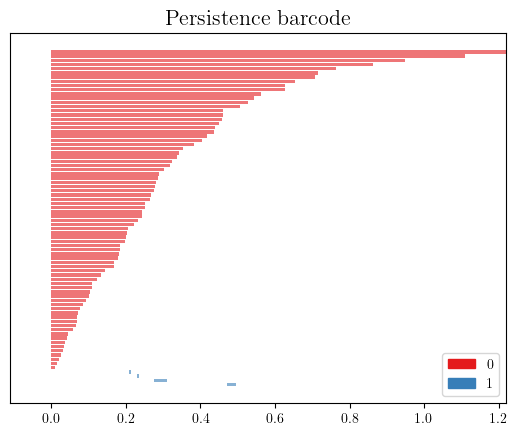

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [42]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizerFast

def cluster_and_get_words(context, sentence, eps=0.1):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained("dicta-il/alephbertgimmel-base")


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_words(output, text[i]))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(words)}")

Clusters for text 0:
Cluster 0: [CLS], שלנו, נסענו, הנגב, המרשימים, המיוחד, המוחלט, במדבר, המרגשות, השמש, המדבר, ההרים, ##כלת, במדבר, החוויה, נשכחת, [SEP]
Cluster 1: החוויות, ביותר


Tokens of the sub-collection: ['לצפות', 'בזר', '##חת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         0.47132816 0.61854918 0.53367489]
 [0.47132816 0.         0.44857698 0.40303469]
 [0.61854918 0.44857698 0.         0.32272062]
 [0.53367489 0.40303469 0.32272062 0.        ]]


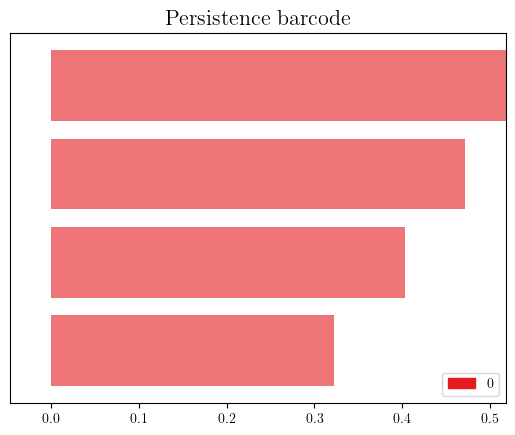

[(0, (0.0, inf)),
 (0, (0.0, 0.4713281576644978)),
 (0, (0.0, 0.4030346867899572)),
 (0, (0.0, 0.3227206223473815))]

In [43]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("dicta-il/alephbertgimmel-base")

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    print(f'Distance matrix: {distances.shape}')
    print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
compute_phrase_distances_and_homology(context[0], text[0], "לצפות בזרחת השמש")

In [44]:
text_2 = ["במהלך שנת הלימודים הראשונה שלי באוניברסיטה, הצטרפתי לקבוצת טיול שהגיעה להר האייפל. למרות הקור החודר, הייתי מחויב לעלות לפסגה בכל בוקר, כדי לצפות בזרחת השמש מעל פריס"]

Tokens of the sub-collection: ['לצפות', 'בזר', '##חת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         0.45067816 0.67154607 0.74177441]
 [0.45067816 0.         0.37688415 0.45457449]
 [0.67154607 0.37688415 0.         0.20828307]
 [0.74177441 0.45457449 0.20828307 0.        ]]


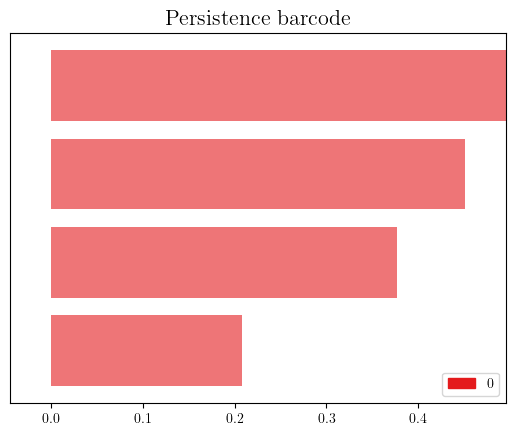

[(0, (0.0, inf)),
 (0, (0.0, 0.450678164443104)),
 (0, (0.0, 0.3768841494096783)),
 (0, (0.0, 0.20828306772108313))]

In [45]:
context_2 = [compute_output(t, layer, head) for t in text_2]
compute_phrase_distances_and_homology(context_2[0], text_2[0], "לצפות בזרחת השמש")

Tokens of the sub-collection: ['לצפות', 'בזר', '##חת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         0.47132816 0.61854918 0.53367489]
 [0.47132816 0.         0.44857698 0.40303469]
 [0.61854918 0.44857698 0.         0.32272062]
 [0.53367489 0.40303469 0.32272062 0.        ]]


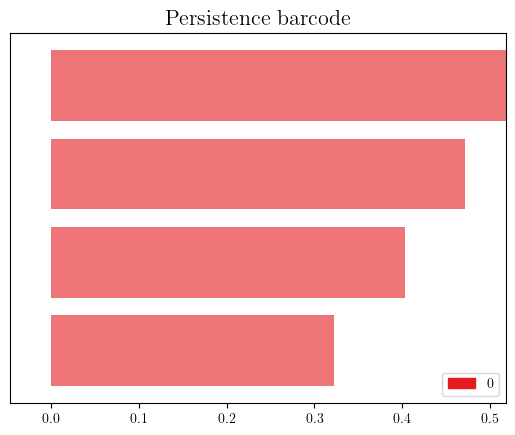

Tokens of the sub-collection: ['לצפות', 'בזר', '##חת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         0.45067816 0.67154607 0.74177441]
 [0.45067816 0.         0.37688415 0.45457449]
 [0.67154607 0.37688415 0.         0.20828307]
 [0.74177441 0.45457449 0.20828307 0.        ]]


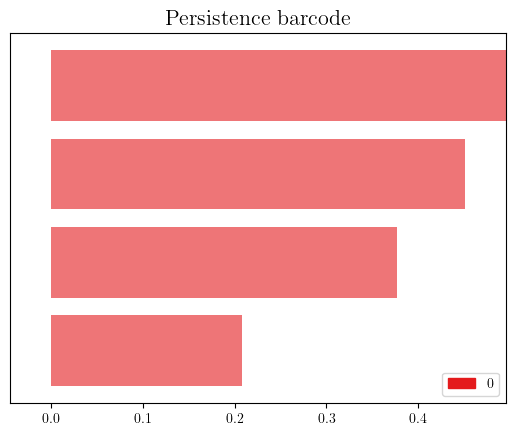

Bottleneck distance: 0.1144375546262984
Wasserstein distance: = 0.16


In [46]:
# from gudhi.wasserstein import wasserstein_distance 
# Could also be: 
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "לצפות בזרחת השמש")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "לצפות בזרחת השמש")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

In [47]:
text_3 = ["הלמידה העמוקה היא תת תחום של הלמידה החישובית המשתמשת ברשתות נוירוניות מלאכותיות. בעזרת אלגוריתמים מורכבים, הלמידה העמוקה מאפשרת למחשבים ללמוד מתוך נתונים מרובים המתארים מציאות מסוימת. המטרה העיקרית של הלמידה העמוקה היא חקירת איך ניתן להגיע למסקנות מדויקות באמצעות הפעלת תהליכים חישוביים מרובים."]

text_4 = ["חישוב קוואנטי הוא תחום במדע המחשב המתמקד בפיתוח מחשבים המבוססים על מכניקת הקוונטים. בניגוד למחשבים קלאסיים, מחשב קוואנטי מסוגל לבצע חישובים מרובים בו זמנית, מה שמאפשר לו לפתור בעיות מורכבות בצורה מהירה יותר. בחישוב הקוואנטי, המטרה העיקרית היא להגיע למסקנות מדויקות באמצעות הפעלת תהליכים חישוביים מרובים."]

In [57]:
context_3 = [compute_output(t, layer, head) for t in text_3]

context_4 = [compute_output(t, layer, head) for t in text_4]

Tokens of the sub-collection: ['למסקנות', 'מדויקות']
Distance matrix: (2, 2)
Distance matrix: [[0.         1.21669723]
 [1.21669723 0.        ]]


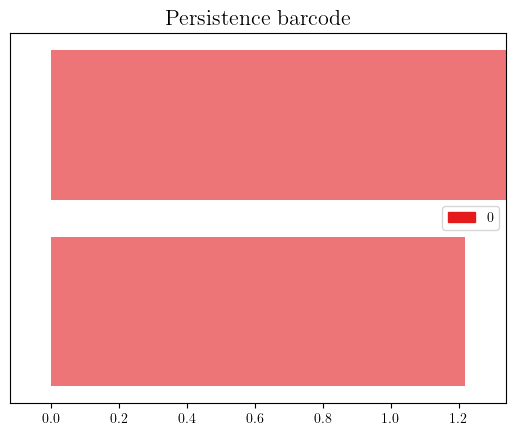

Tokens of the sub-collection: ['למסקנות', 'מדויקות']
Distance matrix: (2, 2)
Distance matrix: [[0.         0.97133093]
 [0.97133093 0.        ]]


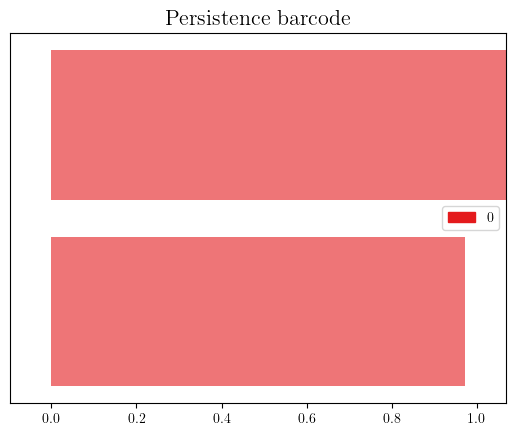

Bottleneck distance: 0.24536629920959996
Wasserstein distance: = 0.25


In [58]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "למסקנות מדויקות")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "למסקנות מדויקות")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

Tokens of the sub-collection: ['להגיע', 'למסקנות', 'מדויקות', 'באמצעות', 'הפעלת', 'תהליכים', 'חישובי', '##ים', 'מרובים']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.96393314 0.54417737 0.5924095  0.59564276 0.72315494
  0.86142939 0.60827759 0.61006116]
 [0.96393314 0.         1.21669723 1.28383866 1.24166379 1.17636075
  1.42118607 1.30315888 1.30516944]
 [0.54417737 1.21669723 0.         0.13917338 0.57285955 0.61646897
  0.66954204 0.14796129 0.14205675]
 [0.5924095  1.28383866 0.13917338 0.         0.58210368 0.6296389
  0.69349904 0.10978423 0.07515129]
 [0.59564276 1.24166379 0.57285955 0.58210368 0.         0.50121413
  0.7084856  0.59555776 0.58322655]
 [0.72315494 1.17636075 0.61646897 0.6296389  0.50121413 0.
  0.71554561 0.62821824 0.6232138 ]
 [0.86142939 1.42118607 0.66954204 0.69349904 0.7084856  0.71554561
  0.         0.65398562 0.65940386]
 [0.60827759 1.30315888 0.14796129 0.10978423 0.59555776 0.62821824
  0.65398562 0.         0.0816829 ]
 [0.61006116 1.

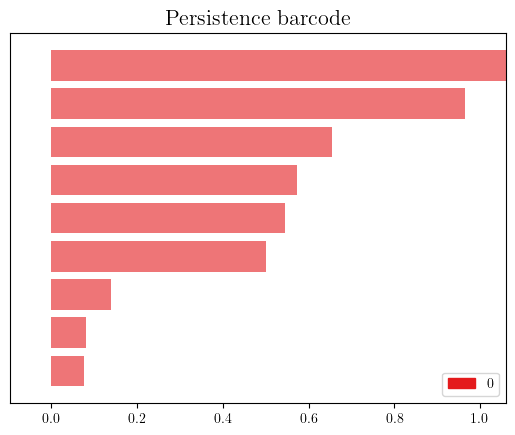

Tokens of the sub-collection: ['להגיע', 'למסקנות', 'מדויקות', 'באמצעות', 'הפעלת', 'תהליכים', 'חישובי', '##ים', 'מרובים']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.89066727 0.24773783 0.24858719 0.53041707 0.7042765
  0.65901649 0.2981515  0.27815553]
 [0.89066727 0.         0.97133093 1.01946554 1.01315357 0.97681417
  1.10566263 1.03629965 1.04016893]
 [0.24773783 0.97133093 0.         0.1350042  0.61602182 0.70031138
  0.63701893 0.16394696 0.13548967]
 [0.24858719 1.01946554 0.1350042  0.         0.60477368 0.70497975
  0.65860527 0.17021861 0.10067304]
 [0.53041707 1.01315357 0.61602182 0.60477368 0.         0.54341018
  0.62975829 0.6371178  0.61413126]
 [0.7042765  0.97681417 0.70031138 0.70497975 0.54341018 0.
  0.67808058 0.71312927 0.70020359]
 [0.65901649 1.10566263 0.63701893 0.65860527 0.62975829 0.67808058
  0.         0.62347167 0.62672646]
 [0.2981515  1.03629965 0.16394696 0.17021861 0.6371178  0.71312927
  0.62347167 0.         0.11919703]
 [0.27815553 1.

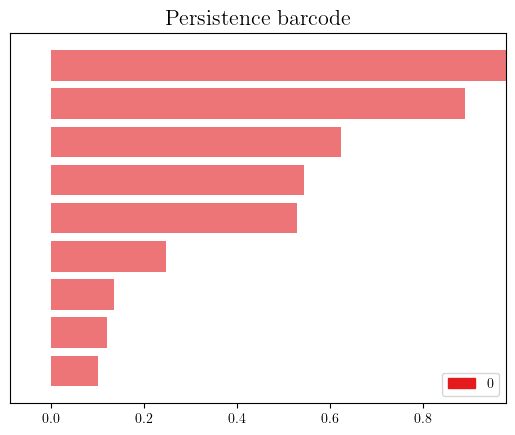

Bottleneck distance: 0.250607066597864
Wasserstein distance: = 0.47


In [59]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0],  "להגיע למסקנות מדויקות באמצעות הפעלת תהליכים חישוביים מרובים")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0],  "להגיע למסקנות מדויקות באמצעות הפעלת תהליכים חישוביים מרובים")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")